In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

# Change the current directory to our project folder
os.chdir('/content/drive/MyDrive/Lip_Read_DNN_Project')

Mounted at /content/drive


In [2]:
# os.makedirs('./temp')

# Install and Import Dependencies

- imageio -- To read and write on video format and to able see couples of frames stacked together
- gdown -- To download dataset from G-Drive

In [3]:
%pip install opencv-python matplotlib imageio gdown tensorflow

In [4]:
%pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.12
albumentations                   1.4.11
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.7.22.0.34.13
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

- To prevent any exponential memory growth

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Build Data Loading Functions
Two key data loading functions
- First, to load our videos
- Second, to preprocess our annotations

Here, annotations --> sentences in our video

In [55]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=c4537f14-773d-4a6a-ad69-6fc6c4005362
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 180MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
### ---------------- NOTE - If you're using google colab ---------------- ###

# Move all the data under project file
import shutil

destination_dir = '/content/drive/MyDrive/Lip_Read_DNN_Project'

# Create the destination directory if it does not exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Move the extracted files to the destination directory
shutil.move('data', destination_dir)

'/content/drive/MyDrive/Lip_Read_DNN_Project/data'

In [4]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)  # Reducing dimensions

        # For isolating the mouth region
        frames.append(frame[190:236,80:220,:])  ## Precise coordinator can find using DLib (follow research paper --> LipNet paper (Google))
                                                ## here, we just give staticly straight-forward
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std

In [5]:
# Every single character which we might expect to encounter within our annotations

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
### ----------- Setting up our vocabulary ------------ ###

# StringLookup --> to convert characters to numbers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [7]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [9]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [10]:
# Function to load up our allignements
# Allignments --> numbers (time intervals) and words from the video (e.g., file - data/alignments/s1/_name_.align )
                  ## e.g., 0 2350 sil --> start time:0, end time: 2.3 sec, word: sil (silence)

def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []

    for line in lines:
        line = line.split()
        if line[2] != 'sil':  # Silence -- we don't need this unnecessary line
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
# Example of above function

temp = [' ', 'abc', ' ', 'def', ' ', '1'] # tokens

print(tf.strings.unicode_split(temp, input_encoding='UTF-8'))

print(tf.reshape(tf.strings.unicode_split(temp, input_encoding='UTF-8'), (-1)))

print(char_to_num(tf.reshape(tf.strings.unicode_split(temp, input_encoding='UTF-8'), (-1))))

<tf.RaggedTensor [[b' '], [b'a', b'b', b'c'], [b' '], [b'd', b'e', b'f'], [b' '], [b'1']]>
tf.Tensor([b' ' b'a' b'b' b'c' b' ' b'd' b'e' b'f' b' ' b'1'], shape=(10,), dtype=string)
tf.Tensor([39  1  2  3 39  4  5  6 39 30], shape=(10,), dtype=int64)


Now, we need to go and load the alignments and videos simultaneously..

So we're going to extract both of those paths and we're going to return the preprocessed videos and alignments together

In [12]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [13]:
test_path = './data/s1/bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [16]:
frames.shape

TensorShape([75, 46, 140, 1])

Here, In above output,

- 75 pixels -- frames in length
- 46 -- height
- 140 -- wide (width)
- 1 -- channel (RGB)

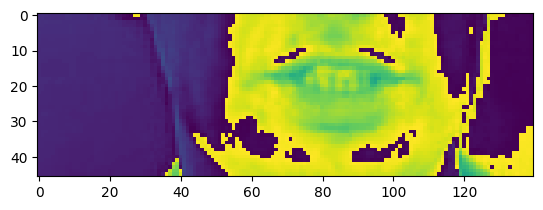

In [17]:
plt.imshow(frames[35])

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [19]:
alignments.shape

TensorShape([21])

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
# Need for our data pipeline --> Used to train our Deep Learning model

def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [22]:
from matplotlib import pyplot as plt

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE) # -- Prefetches data to optimize pipeline performance
                                       # -- TensorFlow automatically decides the optimal number of elements to prefetch based on the
                                       #    available CPU/GPU resources and the current load on the system.

# Added for split
train = data.take(450)
test = data.skip(450) # Validation data

In [24]:
len(test)

50

In [25]:
# To grab the next instances out of our data pipeline
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next();
val[0]

array([[[[[ 1.3868523 ],
          [ 1.3868523 ],
          [ 1.3868523 ],
          ...,
          [ 0.19812176],
          [ 0.11887305],
          [ 0.11887305]],

         [[ 1.3868523 ],
          [ 1.3868523 ],
          [ 1.3868523 ],
          ...,
          [ 0.19812176],
          [ 0.11887305],
          [ 0.11887305]],

         [[ 1.4264766 ],
          [ 1.4264766 ],
          [ 1.3868523 ],
          ...,
          [ 0.2377461 ],
          [ 0.1584974 ],
          [ 0.1584974 ]],

         ...,

         [[ 1.0302331 ],
          [ 0.99060875],
          [ 0.99060875],
          ...,
          [10.064585  ],
          [10.064585  ],
          [10.064585  ]],

         [[ 0.99060875],
          [ 0.99060875],
          [ 0.99060875],
          ...,
          [10.0249605 ],
          [10.0249605 ],
          [10.0249605 ]],

         [[ 0.99060875],
          [ 0.99060875],
          [ 0.99060875],
          ...,
          [10.0249605 ],
          [10.0249605 ],
          

In [29]:
val[0][1].shape

(75, 46, 140, 1)

In [30]:
### ------------ Converts numpy arrays to GIF ---------------- ###
'''
val[0][0] --> List of array of images (frames)
fps --> 10 framed per second
'''
frames1 = val[0][1]
frames1 = (frames1 * 255).astype(np.uint8)

# Remove the single channel dimension if necessary
frames1 = np.squeeze(frames1, axis=-1)

imageio.mimsave('./animation.gif', frames1, fps=10)

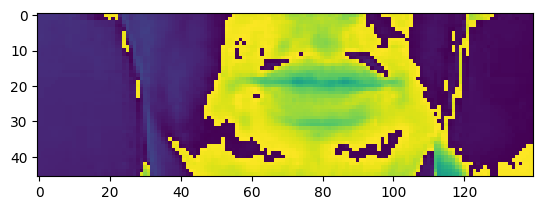

In [31]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red in q six now'>

# 3. Design the Deep Neural Network

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import Accuracy, Precision, Recall

In [34]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [35]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [37]:
yhat = model.predict(val[0])

1/1 [==============================] - 13s 13s/step


In [38]:
yhat[0].shape

(75, 41)

In [39]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([25, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31])>

In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'y66666666666666666666666666666666666666666666666666666666666666662222222222'>

In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'y66666666666666666666666666666666666666666666666666666666666666662222222222'>

In [42]:
model.input_shape

(None, 75, 46, 140, 1)

In [43]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [44]:
# Define a Learning Rate

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

### Note:
- We'll predict single layers at a time, so for that we'll use special function loss function ```CTC (Connectionist Temporal Classification)```
***CTC - Calculates loss between a continuous (unsegmented) time series and a target sequence.**

Reason behind using this loss function:
- It works great when we have word transcriptions that aren't specifically applied to frames
- Given to the structure of this model, it's likely to repeat the same letter or word multiple times..
- If we use a standard cross-entropy loss function, this would look like our model's way up.
- **CTC** is built for this and reduced the duplicates using a special token.

In [45]:
# Taking from the "Automatic Speech Recognition Using CTC"
# For more information -- https://keras.io/examples/audio/ctc_asr/#model

def CTCLoss(y_true, y_pred):   # y_true --> alignments || y_pred --> one hot encoded pred
    # Get the batch size
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    # Get the sequence length of predictions -- 75
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    # Get the sequence length of true labels -- 40
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Create tensors with the same length for all batches
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Compute the CTC loss using Keras backend function
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
# Outputting our predictions

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [47]:
tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()

array([[35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31,
        35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31,
        35, 31, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [35, 25, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31,
        35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31, 35, 31,
        35, 31, 28, 31, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [60]:
# model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[Accuracy(), Precision(), Recall()])

### Callbacks
Utilities to monitor and control the training process.


In [49]:
# Callback to save the model after every epoch or when an improvement is observed
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [50]:
# To dynamically adjusts the learning rate during training according to a schedule
schedule_callback = LearningRateScheduler(scheduler)

In [51]:
example_callback = ProduceExample(test)

In [53]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [56]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=a0b82dbe-1abe-48cd-a6c9-1952d58c9325
To: /content/drive/MyDrive/Lip_Read_DNN_Project/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 140MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [61]:
model.load_weights('models/checkpoint')

In [62]:
test_data = test.as_numpy_iterator()

In [64]:
sample = test_data.next()

In [71]:
yhat = model.predict(sample[0])

1/1 [==============================] - 15s 15s/step


In [72]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green in d four now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white with k five soon'>]

In [73]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [74]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green in d four now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white with k five soon'>]

# Test on a Video

In [75]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [76]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [77]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 7s 7s/step


In [78]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [80]:
print('~'*10, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

# PUSH a code to GitHub